# Baseline Linear Models for Depression Prediction

This notebook implements simple linear regression models using PyTorch to predict clinical scores:
- **PHQ9_F**: Depression (PHQ-9 final score)
- **GAD7_F**: Anxiety (GAD-7 final score)
- **ISI_F**: Insomnia (ISI final score)

## Model Configurations
1. Survey (demographics) + Sleep Diary
2. Survey (demographics) + Sensor HRV
3. Survey (demographics) + Sleep Diary + Sensor HRV

## Regularization
- Ridge (L2 regularization)
- Lasso (L1 regularization)

## 1. Imports & Setup

In [1]:
import sys
import os

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from typing import Dict, List, Tuple, Optional

from src.utils.merged_dataloaders import (
    get_merged_survey_diary_loader,
    get_merged_survey_sensor_loader,
    get_merged_all_loader
)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Data Loading

In [2]:
# Data paths
DATA_DIR = os.path.join(project_root, 'data')
SURVEY_PATH = os.path.join(DATA_DIR, 'survey.csv')
DIARY_PATH = os.path.join(DATA_DIR, 'sleep_diary.csv')
SENSOR_PATH = os.path.join(DATA_DIR, 'sensor_hrv.csv')

# Target labels
TARGET_LABELS = ['PHQ9_F', 'GAD7_F', 'ISI_F']

# Common arguments for data loaders
survey_args = {
    'id_col': 'deviceId',
    'feature_cols': None,  # Use defaults
    'label_cols': TARGET_LABELS,
    'normalize': True,
    'nan_fill_value': 0.0
}

diary_args = {
    'id_col': 'userId',
    'feature_cols': None,  # Use defaults
    'sort_by_col': 'date',
    'normalize': True
}

sensor_args = {
    'mode': 'user',
    'feature_cols': None,  # Use defaults
    'normalize': True
}

In [3]:
# Load all data (get full dataset in one batch)
def load_all_data():
    """Load complete dataset using merged data loader."""
    loader = get_merged_all_loader(
        survey_csv=SURVEY_PATH,
        diary_csv=DIARY_PATH,
        sensor_csv=SENSOR_PATH,
        survey_args=survey_args,
        diary_args=diary_args,
        sensor_args=sensor_args,
        batch_size=100,  # Large enough to get all samples
        shuffle=False
    )
    return next(iter(loader))

# Load data
data_batch = load_all_data()

# Print data shapes
print("Data loaded successfully!")
print(f"\nNumber of participants: {len(data_batch['user_ids'])}")
print(f"Survey features shape: {data_batch['survey_features'].shape}")
print(f"Survey labels shape: {data_batch['survey_labels'].shape}")
print(f"Diary features shape: {data_batch['diary_features'].shape}")
print(f"Sensor features shape: {data_batch['sensor_features'].shape}")

Data loaded successfully!

Number of participants: 49
Survey features shape: torch.Size([49, 11])
Survey labels shape: torch.Size([49, 3])
Diary features shape: torch.Size([49, 28, 6])
Sensor features shape: torch.Size([49, 4576, 14])


## 3. Feature Aggregation Functions

Convert variable-length sequences (diary, sensor) to fixed-length feature vectors using statistical aggregates.

In [4]:
def aggregate_sequences(seq_tensor: torch.Tensor, lengths: torch.Tensor) -> torch.Tensor:
    """
    Aggregate variable-length sequences to fixed-length features.
    
    Computes mean, std, min, max for each feature across the time dimension.
    
    Args:
        seq_tensor: Tensor of shape (B, max_len, F)
        lengths: Tensor of shape (B,) with actual sequence lengths
        
    Returns:
        Aggregated features of shape (B, F*4)
    """
    batch_size = seq_tensor.shape[0]
    num_features = seq_tensor.shape[2]
    aggregated = []
    
    for i in range(batch_size):
        length = int(lengths[i].item())
        if length == 0:
            # Handle empty sequences
            stats = torch.zeros(num_features * 4)
        else:
            seq = seq_tensor[i, :length, :]  # (length, F)
            
            mean_vals = seq.mean(dim=0)
            std_vals = seq.std(dim=0) if length > 1 else torch.zeros(num_features)
            min_vals = seq.min(dim=0)[0]
            max_vals = seq.max(dim=0)[0]
            
            stats = torch.cat([mean_vals, std_vals, min_vals, max_vals])
        
        aggregated.append(stats)
    
    return torch.stack(aggregated)


def prepare_features(
    batch: Dict[str, torch.Tensor],
    use_diary: bool = False,
    use_sensor: bool = False
) -> torch.Tensor:
    """
    Prepare feature matrix by combining survey features with aggregated sequences.
    
    Args:
        batch: Data batch dictionary
        use_diary: Whether to include sleep diary features
        use_sensor: Whether to include sensor HRV features
        
    Returns:
        Combined feature tensor of shape (B, total_features)
    """
    features_list = [batch['survey_features']]
    
    if use_diary and 'diary_features' in batch:
        diary_agg = aggregate_sequences(
            batch['diary_features'],
            batch['diary_lengths']
        )
        features_list.append(diary_agg)
    
    if use_sensor and 'sensor_features' in batch:
        sensor_agg = aggregate_sequences(
            batch['sensor_features'],
            batch['sensor_lengths']
        )
        features_list.append(sensor_agg)
    
    return torch.cat(features_list, dim=1)

In [5]:
# Test feature preparation for each configuration
X_survey_diary = prepare_features(data_batch, use_diary=True, use_sensor=False)
X_survey_sensor = prepare_features(data_batch, use_diary=False, use_sensor=True)
X_all = prepare_features(data_batch, use_diary=True, use_sensor=True)

print("Feature dimensions for each configuration:")
print(f"Survey + Diary: {X_survey_diary.shape}")
print(f"Survey + Sensor: {X_survey_sensor.shape}")
print(f"Survey + Diary + Sensor: {X_all.shape}")

Feature dimensions for each configuration:
Survey + Diary: torch.Size([49, 35])
Survey + Sensor: torch.Size([49, 67])
Survey + Diary + Sensor: torch.Size([49, 91])


## 4. PyTorch Linear Regression Model

In [6]:
class LinearRegressor(nn.Module):
    """
    Simple linear regression model for predicting clinical scores.
    """
    
    def __init__(self, input_dim: int, output_dim: int = 1):
        """
        Args:
            input_dim: Number of input features
            output_dim: Number of output targets (default 1)
        """
        super(LinearRegressor, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)
    
    def get_weights(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """Return model weights and bias."""
        return self.linear.weight.data, self.linear.bias.data

In [7]:
def compute_regularization(model: nn.Module, reg_type: str, alpha: float) -> torch.Tensor:
    """
    Compute regularization penalty.
    
    Args:
        model: PyTorch model
        reg_type: 'l1' (Lasso), 'l2' (Ridge), or 'none'
        alpha: Regularization strength
        
    Returns:
        Regularization loss term
    """
    if reg_type == 'none' or alpha == 0:
        return torch.tensor(0.0)
    
    reg_loss = torch.tensor(0.0)
    for param in model.parameters():
        if reg_type == 'l1':  # Lasso
            reg_loss = reg_loss + torch.sum(torch.abs(param))
        elif reg_type == 'l2':  # Ridge
            reg_loss = reg_loss + torch.sum(param ** 2)
    
    return alpha * reg_loss

## 5. Training Function with Leave-One-Out Cross-Validation

In [8]:
def train_model(
    X: torch.Tensor,
    y: torch.Tensor,
    reg_type: str = 'l2',
    alpha: float = 0.01,
    lr: float = 0.01,
    epochs: int = 1000,
    verbose: bool = False
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train linear model using Leave-One-Out Cross-Validation.
    
    Args:
        X: Feature tensor of shape (N, F)
        y: Target tensor of shape (N,) or (N, 1)
        reg_type: 'l1' (Lasso), 'l2' (Ridge), or 'none'
        alpha: Regularization strength
        lr: Learning rate
        epochs: Number of training epochs
        verbose: Whether to print progress
        
    Returns:
        Tuple of (predictions, actuals) arrays
    """
    n_samples = X.shape[0]
    input_dim = X.shape[1]
    
    # Ensure y is 2D
    if y.dim() == 1:
        y = y.unsqueeze(1)
    
    predictions = []
    actuals = []
    
    # Leave-One-Out CV
    for i in range(n_samples):
        # Split data
        train_mask = torch.ones(n_samples, dtype=torch.bool)
        train_mask[i] = False
        
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_test = X[i:i+1]
        y_test = y[i:i+1]
        
        # Initialize model
        model = LinearRegressor(input_dim, output_dim=1)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.MSELoss()
        
        # Training loop
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            # Forward pass
            y_pred = model(X_train)
            
            # Compute loss with regularization
            mse_loss = criterion(y_pred, y_train)
            reg_loss = compute_regularization(model, reg_type, alpha)
            loss = mse_loss + reg_loss
            
            # Backward pass
            loss.backward()
            optimizer.step()
        
        # Predict on held-out sample
        model.eval()
        with torch.no_grad():
            pred = model(X_test)
        
        predictions.append(pred.item())
        actuals.append(y_test.item())
        
        if verbose and (i + 1) % 10 == 0:
            print(f"  Completed {i + 1}/{n_samples} folds")
    
    return np.array(predictions), np.array(actuals)

In [9]:
def compute_metrics(predictions: np.ndarray, actuals: np.ndarray) -> Dict[str, float]:
    """
    Compute regression evaluation metrics.
    
    Args:
        predictions: Predicted values
        actuals: Actual values
        
    Returns:
        Dictionary with MAE, RMSE, R2 scores
    """
    mae = np.mean(np.abs(predictions - actuals))
    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    
    # R-squared
    ss_res = np.sum((actuals - predictions) ** 2)
    ss_tot = np.sum((actuals - np.mean(actuals)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

## 6. Run Experiments

Train and evaluate all model configurations.

In [10]:
# Experiment configuration
CONFIGS = {
    'Survey + Diary': {'use_diary': True, 'use_sensor': False},
    'Survey + Sensor': {'use_diary': False, 'use_sensor': True},
    'Survey + Diary + Sensor': {'use_diary': True, 'use_sensor': True}
}

REG_TYPES = {
    'Ridge': 'l2',
    'Lasso': 'l1'
}

# Hyperparameters
ALPHA = 0.01  # Regularization strength
LR = 0.01     # Learning rate
EPOCHS = 500  # Training epochs

# Get targets
y = data_batch['survey_labels']  # Shape: (N, 3)

In [11]:
# Store all results
results = []

# Run experiments
for config_name, config_params in CONFIGS.items():
    print(f"\n{'='*60}")
    print(f"Configuration: {config_name}")
    print(f"{'='*60}")
    
    # Prepare features for this configuration
    X = prepare_features(data_batch, **config_params)
    print(f"Feature dimension: {X.shape[1]}")
    
    for reg_name, reg_type in REG_TYPES.items():
        print(f"\n  {reg_name} Regression:")
        print(f"  {'-'*40}")
        
        for target_idx, target_name in enumerate(TARGET_LABELS):
            # Get target values
            y_target = y[:, target_idx]
            
            # Train and evaluate
            predictions, actuals = train_model(
                X, y_target,
                reg_type=reg_type,
                alpha=ALPHA,
                lr=LR,
                epochs=EPOCHS,
                verbose=False
            )
            
            # Compute metrics
            metrics = compute_metrics(predictions, actuals)
            
            # Store results
            results.append({
                'Configuration': config_name,
                'Regularization': reg_name,
                'Target': target_name,
                'MAE': metrics['MAE'],
                'RMSE': metrics['RMSE'],
                'R2': metrics['R2']
            })
            
            print(f"    {target_name}: MAE={metrics['MAE']:.3f}, RMSE={metrics['RMSE']:.3f}, R²={metrics['R2']:.3f}")

print(f"\n{'='*60}")
print("All experiments completed!")
print(f"{'='*60}")


Configuration: Survey + Diary
Feature dimension: 35

  Ridge Regression:
  ----------------------------------------
    PHQ9_F: MAE=2.938, RMSE=3.755, R²=-0.033
    GAD7_F: MAE=2.015, RMSE=2.434, R²=0.145
    ISI_F: MAE=3.508, RMSE=4.732, R²=-0.068

  Lasso Regression:
  ----------------------------------------
    PHQ9_F: MAE=2.940, RMSE=3.807, R²=-0.062
    GAD7_F: MAE=2.015, RMSE=2.457, R²=0.129
    ISI_F: MAE=3.532, RMSE=4.810, R²=-0.103

Configuration: Survey + Sensor
Feature dimension: 67

  Ridge Regression:
  ----------------------------------------
    PHQ9_F: MAE=21.636, RMSE=126.182, R²=-1165.714
    GAD7_F: MAE=18.313, RMSE=110.091, R²=-1747.605
    ISI_F: MAE=13.715, RMSE=65.657, R²=-204.494

  Lasso Regression:
  ----------------------------------------
    PHQ9_F: MAE=33.202, RMSE=208.229, R²=-3176.242
    GAD7_F: MAE=23.978, RMSE=149.786, R²=-3235.904
    ISI_F: MAE=15.876, RMSE=80.032, R²=-304.329

Configuration: Survey + Diary + Sensor
Feature dimension: 91

  Ridge 

## 7. Results Summary

In [12]:
# Create results DataFrame
results_df = pd.DataFrame(results)

# Display full results
print("\nComplete Results Table:")
print(results_df.to_string(index=False))


Complete Results Table:
          Configuration Regularization Target       MAE       RMSE           R2
         Survey + Diary          Ridge PHQ9_F  2.937894   3.755280    -0.033364
         Survey + Diary          Ridge GAD7_F  2.014654   2.434477     0.144938
         Survey + Diary          Ridge  ISI_F  3.507811   4.732241    -0.067508
         Survey + Diary          Lasso PHQ9_F  2.939754   3.806741    -0.061880
         Survey + Diary          Lasso GAD7_F  2.014503   2.457167     0.128924
         Survey + Diary          Lasso  ISI_F  3.532499   4.809628    -0.102708
        Survey + Sensor          Ridge PHQ9_F 21.635931 126.182130 -1165.714094
        Survey + Sensor          Ridge GAD7_F 18.312514 110.091184 -1747.605038
        Survey + Sensor          Ridge  ISI_F 13.715212  65.657038  -204.494415
        Survey + Sensor          Lasso PHQ9_F 33.201997 208.228789 -3176.241893
        Survey + Sensor          Lasso GAD7_F 23.977676 149.786118 -3235.903664
        Survey 

In [13]:
# Pivot table for better visualization
print("\n" + "="*60)
print("Results by Target and Configuration (R² scores)")
print("="*60)

pivot_r2 = results_df.pivot_table(
    values='R2',
    index=['Configuration', 'Regularization'],
    columns='Target'
)
print(pivot_r2.round(3))


Results by Target and Configuration (R² scores)
Target                                    GAD7_F    ISI_F    PHQ9_F
Configuration           Regularization                             
Survey + Diary          Lasso              0.129   -0.103    -0.062
                        Ridge              0.145   -0.068    -0.033
Survey + Diary + Sensor Lasso            -36.603  -64.405  -499.905
                        Ridge           -119.661   -0.696   -55.744
Survey + Sensor         Lasso          -3235.904 -304.329 -3176.242
                        Ridge          -1747.605 -204.494 -1165.714


In [14]:
# Best model for each target
print("\n" + "="*60)
print("Best Model for Each Target (by R²)")
print("="*60)

for target in TARGET_LABELS:
    target_results = results_df[results_df['Target'] == target]
    best_idx = target_results['R2'].idxmax()
    best = target_results.loc[best_idx]
    print(f"\n{target}:")
    print(f"  Config: {best['Configuration']} + {best['Regularization']}")
    print(f"  R²={best['R2']:.3f}, MAE={best['MAE']:.3f}, RMSE={best['RMSE']:.3f}")


Best Model for Each Target (by R²)

PHQ9_F:
  Config: Survey + Diary + Ridge
  R²=-0.033, MAE=2.938, RMSE=3.755

GAD7_F:
  Config: Survey + Diary + Ridge
  R²=0.145, MAE=2.015, RMSE=2.434

ISI_F:
  Config: Survey + Diary + Ridge
  R²=-0.068, MAE=3.508, RMSE=4.732


In [15]:
# Save results to CSV
output_dir = os.path.join(project_root, 'test_logs')
os.makedirs(output_dir, exist_ok=True)

output_path = os.path.join(output_dir, 'baseline_linear_results.csv')
results_df.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")


Results saved to: /Users/aritra/Documents/01_Project/Fall_2025/DSC_291_Mobile/project/depression-pred-sensor-291-UCSD/test_logs/baseline_linear_results.csv


## 8. Visualization

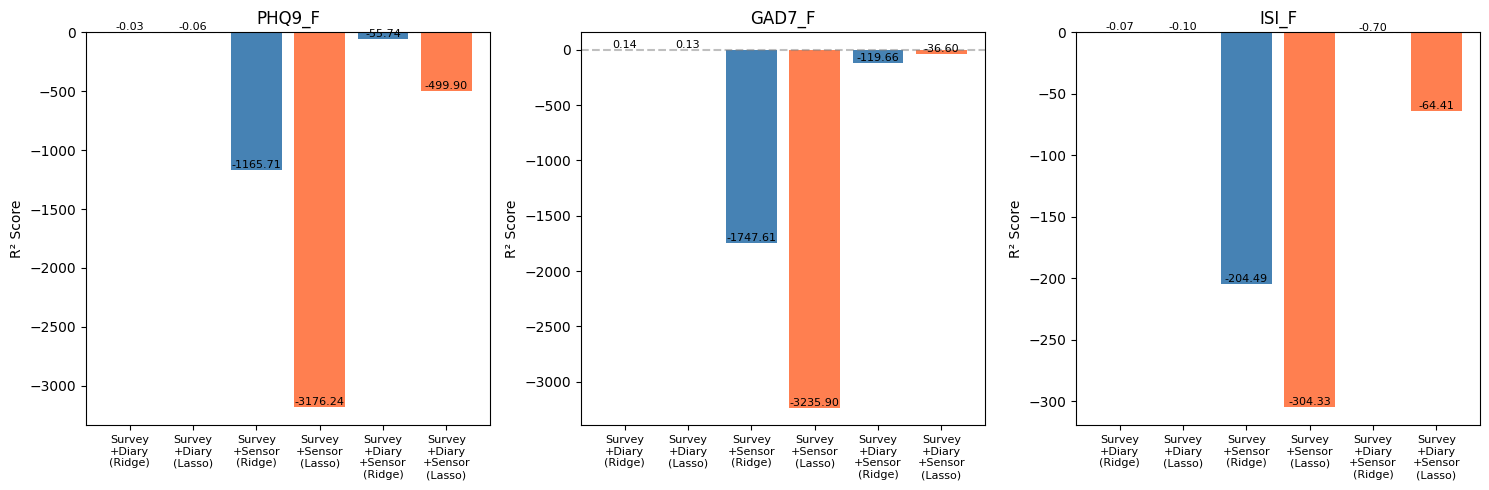


Plot saved to: /Users/aritra/Documents/01_Project/Fall_2025/DSC_291_Mobile/project/depression-pred-sensor-291-UCSD/test_logs/baseline_linear_results.png


In [17]:
import matplotlib.pyplot as plt

# Create comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, target in enumerate(TARGET_LABELS):
    ax = axes[idx]
    target_results = results_df[results_df['Target'] == target]
    
    # Prepare data for plotting
    x_labels = []
    r2_values = []
    colors = []
    
    for _, row in target_results.iterrows():
        config_label = row['Configuration'].replace(' + ', '\n+')
        label = f"{config_label}\n({row['Regularization']})"
        x_labels.append(label)
        r2_values.append(row['R2'])
        colors.append('steelblue' if row['Regularization'] == 'Ridge' else 'coral')
    
    bars = ax.bar(range(len(x_labels)), r2_values, color=colors)
    ax.set_xticks(range(len(x_labels)))
    ax.set_xticklabels(x_labels, fontsize=8)
    ax.set_ylabel('R² Score')
    ax.set_title(f'{target}')
    ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    
    # Add value labels on bars
    for bar, val in zip(bars, r2_values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'baseline_linear_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPlot saved to: {os.path.join(output_dir, 'baseline_linear_results.png')}")

## 9. Hyperparameter Tuning (Optional)

Search for optimal regularization strength.

In [18]:
def tune_alpha(
    X: torch.Tensor,
    y: torch.Tensor,
    reg_type: str,
    alphas: List[float],
    lr: float = 0.01,
    epochs: int = 500
) -> Tuple[float, Dict[str, float]]:
    """
    Find optimal alpha using LOO-CV.
    
    Returns:
        Tuple of (best_alpha, best_metrics)
    """
    best_alpha = alphas[0]
    best_r2 = -np.inf
    best_metrics = {}
    
    for alpha in alphas:
        preds, acts = train_model(X, y, reg_type=reg_type, alpha=alpha, lr=lr, epochs=epochs)
        metrics = compute_metrics(preds, acts)
        
        if metrics['R2'] > best_r2:
            best_r2 = metrics['R2']
            best_alpha = alpha
            best_metrics = metrics
    
    return best_alpha, best_metrics

In [20]:
# Uncomment to run hyperparameter tuning (takes longer)

ALPHAS = [0.001, 0.01, 0.1, 1.0]

print("Hyperparameter Tuning Results:")
print("="*60)

X_best = prepare_features(data_batch, use_diary=True, use_sensor=True)

for target_idx, target_name in enumerate(TARGET_LABELS):
    y_target = y[:, target_idx]
    
    for reg_name, reg_type in REG_TYPES.items():
        best_alpha, best_metrics = tune_alpha(
            X_best, y_target, reg_type, ALPHAS
        )
        print(f"{target_name} ({reg_name}): best_alpha={best_alpha}, R²={best_metrics['R2']:.3f}")

Hyperparameter Tuning Results:
PHQ9_F (Ridge): best_alpha=1.0, R²=-0.046
PHQ9_F (Lasso): best_alpha=1.0, R²=0.236
GAD7_F (Ridge): best_alpha=1.0, R²=-0.446
GAD7_F (Lasso): best_alpha=1.0, R²=-0.052
ISI_F (Ridge): best_alpha=1.0, R²=0.035
ISI_F (Lasso): best_alpha=1.0, R²=0.130
